Extração(LLM) - Recomendação (RecSys) - Review (LLM) 

## IMPORTS 

### Dataset

In [1]:
import pandas as pd
import openai # API openai
import zipfile # Extrair .zip
import json # Trabalhar com JSON
import re


In [2]:
# Importando dados de treino e teste
with zipfile.ZipFile('../data/redial_dataset.zip', 'r') as z:
    z.extractall('../data/')

train_data = []
for line in open("../data/train_data.jsonl", "r"):
    train_data.append(json.loads(line))
print("Loaded {} train conversations".format(len(train_data)))


test_data = []
for line in open("../data/test_data.jsonl", "r"):
    test_data.append(json.loads(line))
print("Loaded {} test conversations".format(len(test_data)))

Loaded 10006 train conversations
Loaded 1342 test conversations


In [3]:
train_data[119]

{'movieMentions': {'119144': 'Wonder Woman  (2017)',
  '138962': 'Bad Moms (2016)',
  '93013': "Daddy's Home  (2015)",
  '184098': 'Guardians of the Galaxy  (2014)'},
 'respondentQuestions': {'119144': {'suggested': 1, 'seen': 1, 'liked': 1},
  '138962': {'suggested': 0, 'seen': 1, 'liked': 0},
  '93013': {'suggested': 0, 'seen': 1, 'liked': 1},
  '184098': {'suggested': 0, 'seen': 0, 'liked': 1}},
 'messages': [{'timeOffset': 0,
   'text': 'Hello',
   'senderWorkerId': 31,
   'messageId': 3210},
  {'timeOffset': 1, 'text': 'Hello!', 'senderWorkerId': 30, 'messageId': 3211},
  {'timeOffset': 8,
   'text': 'How is your day going?',
   'senderWorkerId': 30,
   'messageId': 3212},
  {'timeOffset': 16,
   'text': 'I love movies, have you seen @119144',
   'senderWorkerId': 31,
   'messageId': 3213},
  {'timeOffset': 19,
   'text': 'Can you recommend any good comedy movies?',
   'senderWorkerId': 30,
   'messageId': 3214},
  {'timeOffset': 21,
   'text': 'I am doing good how about u',
   's

In [4]:
# Exemplo de conversa 
conversation = train_data[32]

# Mostrar de forma formatada
print("=== Conversa ID:", conversation["conversationId"], "===")
for msg in conversation["messages"]:
    sender = "Usuário 1" if msg["senderWorkerId"] == conversation["initiatorWorkerId"] else "Usuário 2"
    print(f"{sender}: {msg['text']}")

=== Conversa ID: 485 ===
Usuário 1: Hi can you help me find a musical
Usuário 2: hey what kind of movies interest you
Usuário 2: yes i would love to!
Usuário 1: I really like @127328 and @107350
Usuário 2: have you seen @172129 with Renee Zellwegger, Queen Latifa, and Catherine Zeta Jones
Usuário 2: I like @127328 too!
Usuário 2: oops, I meant @145997
Usuário 1: Yeah I have seen @145997 many times
Usuário 2: what about @124461 for something a little different or even @124268 which was more recent?
Usuário 1: I have not seen @124268 I think I may like that one
Usuário 2: The music is all from ABBA and it is so good
Usuário 2: I hope you will enjoy it as much as I do
Usuário 1: That is great that group does have some good music thanks for the help. Bye
Usuário 2: no problem bye


In [5]:
movie_mentions = conversation.get('movieMentions', {})

print(f"=== Conversa ID: {conversation['conversationId']} ===")

for msg in conversation["messages"]:
    sender = "User 1" if msg["senderWorkerId"] == conversation["initiatorWorkerId"] else "User 2"
    text = msg['text']
    
    # Substitui cada @movieId pelo título do filme
    for movie_id, movie_title in movie_mentions.items():
        text = text.replace(f'@{movie_id}', movie_title)
    
    print(f"{sender}: {text}")

=== Conversa ID: 485 ===
User 1: Hi can you help me find a musical
User 2: hey what kind of movies interest you
User 2: yes i would love to!
User 1: I really like Hairspray  (2007) and Sweeney Todd: The Demon Barber of Fleet Street  (2007)
User 2: have you seen Chicago 10  (2007) with Renee Zellwegger, Queen Latifa, and Catherine Zeta Jones
User 2: I like Hairspray  (2007) too!
User 2: oops, I meant Chicago  (2002)
User 1: Yeah I have seen Chicago  (2002) many times
User 2: what about White Christmas  (1954) for something a little different or even Mamma Mia!  (2008) which was more recent?
User 1: I have not seen Mamma Mia!  (2008) I think I may like that one
User 2: The music is all from ABBA and it is so good
User 2: I hope you will enjoy it as much as I do
User 1: That is great that group does have some good music thanks for the help. Bye
User 2: no problem bye


In [6]:
conversation = train_data[222]

# IDs de usuários
initiator_id = conversation["initiatorWorkerId"]
respondent_id = conversation["respondentWorkerId"]

print("ID do usuário que iniciou a conversa:", initiator_id)
print("ID do usuário que respondeu:", respondent_id)


ID do usuário que iniciou a conversa: 56
ID do usuário que respondeu: 60


## Tratamento e Limpeza dos datasets

In [7]:
def clean_data(dataset):
    """
    Remove diálogos inválidas do dataset 
    """

    invalid_indexes = []

    # Identifica diálogos inválidas
    for i, conv in enumerate(dataset):
        if (
            isinstance(conv.get("movieMentions"), list) # Se for lista em vez de dicionário
            or not isinstance(conv.get("movieMentions", {}), dict) # Se dicionário for inválido
            or "messages" not in conv # Diálogo sem mensagem
            or not conv["messages"] # Diálogo sem mensagem
        ):
            invalid_indexes.append(i)

    # Remove invalidos
    for i in sorted(invalid_indexes, reverse=True):
        del dataset[i]

    print(f"✅ Conversas válidas restantes: {len(dataset)}")
    print(f"🗑️ Conversas removidas: {len(invalid_indexes)}")

clean_data(train_data)
clean_data(test_data)

✅ Conversas válidas restantes: 10005
🗑️ Conversas removidas: 1
✅ Conversas válidas restantes: 1342
🗑️ Conversas removidas: 0


## Extração de itens e Montagem Matriz Usuário-Item (LLM)

### Extração Itens

#### Funções 

In [8]:
# Extração e atitude de user/item

# Formata cada dialogo de JSON para string, separando usuário de sistema 
def format_conversation(conv):

    """
    Formata cada dialogo de JSON para string, separando usuário de sistema 
    """

    msgs = []
    for msg in conv["messages"]:
        sender = "User" if msg["senderWorkerId"] == conv["initiatorWorkerId"] else "System"
        msgs.append(f"{sender}: {msg['text']}")
    return "\n".join(msgs)



def prompt_extraction_items(conv):

    """
    Gera o prompt que será enviado à LLM para extrair os filmes e atribuir ratings (1 a 5) apropriadas de acordo com a atitude do usuário.
    conversation_text = Dialogo
    mentioned_ids = IDs dos filmes mencionados
    filtered_mentions = Mantem apenas os IDs que aparecem na conversa 
    movie_mentions = String com o nome de filmes mencionados
    """

    conversation_text = format_conversation(conv)
    mentioned_ids = re.findall(r'@(\d+)', conversation_text)
    filtered_mentions = {k: v for k, v in conv["movieMentions"].items() if k in mentioned_ids}
    movie_mentions = "\n".join([f"@{k} = {v}" for k, v in filtered_mentions.items()])


#     prompt = f"""
# Pretend you are a movie recommender system. You (a
# recommender system) will be given a full conversation between a user
# and a system. Based on the entire conversation, you need to extract ALL 
# movie names mentioned and analyze the user's final attitude toward each movie.
# You need to reply with standardized movie names (with grammatical errors corrected 
# and abbreviations fixed), as well as the user's attitude toward the movie.


# Movies in the conversation are referred to by tokens like "@12345". The
# user's final attitude toward each movie is represented in one of 
# [1, 2, 3, 4, 5], where 1 stands for very negative, 2 stands for 
# negative, 3 stands for neutral, 4 stands for positive, and 5 stands for 
# very positive. You need to reply with the number as an attitude instead 
# of the textual description. If there are movie names mentioned in the query,
# list each movie name and the user's attitude (number in 0 to
# 5) in the form of movie_name####attitude, where different
# movies are listed in different lines with no extra sentences.
# Reply NO if no movie names are mentioned in the query.

# Use the following mapping to know which movie each token refers to:
# {movie_mentions}

# Important: ONLY consider movies explicitly mentioned (tokens starting with '@'). 
# Do NOT include any other movies even if related or implied.
# If you include any movie not mentioned, your answer will be invalid.

# Conversation:
# {conversation_text}
# """

    prompt = f"""
Pretend you are a movie recommender system. You (a
recommender system) will be given a full conversation between a user
and a system. Based on the entire conversation, you need to extract ALL 
movie ids mentioned and analyze the user's final attitude toward each movie.
You need to reply with movie ids as well as the user's attitude toward the movie.


Movies in the conversation are referred to by tokens like "@12345". The
user's final attitude toward each movie is represented in one of 
[1, 2, 3, 4, 5], where 1 stands for very negative, 2 stands for 
negative, 3 stands for neutral, 4 stands for positive, and 5 stands for 
very positive. You need to reply with the number as an attitude instead 
of the textual description. If there are movie ids mentioned in the query,
list each movie id and the user's attitude (number in 0 to
5) in the form of movie_id####attitude, where different
movies are listed in different lines with no extra sentences.
You must reply ONLY with movie IDs (e.g., 122159), not movie names.
You mus remove the "@" that comes in the beginning of the movie id.


Use the following to know which movie each token refers to:
{movie_mentions}

Important: ONLY consider movies explicitly mentioned (tokens starting with '@'). 
Do NOT include any other movies even if related or implied.
If you include any movie not mentioned, your answer will be invalid.

Conversation:
{conversation_text}

Example output format:
122159####5
84779####4
"""
    return prompt.strip()



def extract_user_movie_rating(conv, llm_response):

    """
    Extrai userId, movieId e rating a partir da resposta da LLM
    """

    user_id = conv["initiatorWorkerId"]
    lines = llm_response.strip().splitlines()
    data = []

    for line in lines:
        if "####" in line:
            movie_id, rating = line.split("####")

            data.append({
                "userId": user_id,
                "movieId": int(movie_id.strip()),
                "rating": int(rating.strip())
            })

    return pd.DataFrame(data)


#### SYNC

In [9]:
# Testar com uma conversa
conv_35 = train_data[35]

# Montagem prompt extração item/rating
prompt = prompt_extraction_items(conv_35)

# Resposta LLM
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "user", "content": prompt}
    ],
    temperature=0
)

print("=== PROMPT ===")
print(prompt)

print("\n=== RESPOSTA ===")
print(response.choices[0].message.content.strip())


# Exemplo com resposta exemplo
llm_response = response.choices[0].message.content.strip()

# Extrai user/item/rating
df_result = extract_user_movie_rating(conv_35, llm_response)

print(df_result)

NameError: name 'client' is not defined

#### ASYNC

In [ ]:
# Execução Assíncrona

async def process_conversation(conv):

    """
    Processa um único diálogo
    """

    prompt = prompt_extraction_items(conv) # Gera prompt

    for attempt in range(3):  # tenta até 3 vezes
        try:
            # Chamada LLM
            response = await client_async.chat.completions.create(
                model="gpt-4o-mini",
                messages=[{"role": "user", "content": prompt}],
                temperature=0
            )

            # Resosta LLM
            content = response.choices[0].message.content.strip()
            if content != "NO":
                return extract_user_movie_rating(conv, content) # Input para matriz usuário item com ratings
            break
        except Exception as e:
            await asyncio.sleep(2) 
    return pd.DataFrame(columns=["userId", "movieId", "rating"]) # Fallback


async def process_dataset(sample_data, batch_size=10):
    """
    Processa vários diálogos em paralelo (batch)
    """
    results = []
    for i in range(0, len(sample_data), batch_size): # Divide dataset em batches
        batch = sample_data[i:i+batch_size]
        tasks = [process_conversation(conv) for conv in batch] # Para cada diálogo no batch, calcula input da matriz
        batch_results = await asyncio.gather(*tasks) # Garante execução em paralelo 
        await asyncio.sleep(2) # evita timeout
        results.extend(batch_results)
        print(f" Processados {i+len(batch)} diálogos")

    df_all = pd.concat(results, ignore_index=True)
    return df_all #Matriz usuário item com ratings



In [ ]:
user_item_train = await process_dataset(train_data, batch_size=40)


 Processados 40 diálogos
 Processados 80 diálogos
 Processados 120 diálogos
 Processados 160 diálogos
 Processados 200 diálogos
 Processados 240 diálogos
 Processados 280 diálogos
 Processados 320 diálogos
 Processados 360 diálogos
 Processados 400 diálogos
 Processados 440 diálogos
 Processados 480 diálogos
 Processados 520 diálogos
 Processados 560 diálogos
 Processados 600 diálogos
 Processados 640 diálogos
 Processados 680 diálogos
 Processados 720 diálogos
 Processados 760 diálogos
 Processados 800 diálogos
 Processados 840 diálogos
 Processados 880 diálogos
 Processados 920 diálogos
 Processados 960 diálogos
 Processados 1000 diálogos
 Processados 1040 diálogos
 Processados 1080 diálogos
 Processados 1120 diálogos
 Processados 1160 diálogos
 Processados 1200 diálogos
 Processados 1240 diálogos
 Processados 1280 diálogos
 Processados 1320 diálogos
 Processados 1360 diálogos
 Processados 1400 diálogos
 Processados 1440 diálogos
 Processados 1480 diálogos
 Processados 1520 diálogos


In [ ]:
user_item_train.to_csv("user_item_train.csv", index=False, sep=";")
user_item_train

,userId,movieId,rating
0,0,84779,4
1,0,191602,4
2,0,122159,4
3,0,151313,4
4,0,203371,4
...,...,...,...
31814,953,204974,5
31815,954,85036,4
31816,954,170277,4
31817,954,149938,3


In [ ]:
user_item_test = await process_dataset(test_data, batch_size=30)


 Processados 30 diálogos
 Processados 60 diálogos
 Processados 90 diálogos
 Processados 120 diálogos
 Processados 150 diálogos
 Processados 180 diálogos
 Processados 210 diálogos
 Processados 240 diálogos
 Processados 270 diálogos
 Processados 300 diálogos
 Processados 330 diálogos
 Processados 360 diálogos
 Processados 390 diálogos
 Processados 420 diálogos
 Processados 450 diálogos
 Processados 480 diálogos
 Processados 510 diálogos
 Processados 540 diálogos
 Processados 570 diálogos
 Processados 600 diálogos
 Processados 630 diálogos
 Processados 660 diálogos
 Processados 690 diálogos
 Processados 720 diálogos
 Processados 750 diálogos
 Processados 780 diálogos
 Processados 810 diálogos
 Processados 840 diálogos
 Processados 870 diálogos
 Processados 900 diálogos
 Processados 930 diálogos
 Processados 960 diálogos
 Processados 990 diálogos
 Processados 1020 diálogos
 Processados 1050 diálogos
 Processados 1080 diálogos
 Processados 1110 diálogos
 Processados 1140 diálogos
 Processad

In [ ]:
user_item_test.to_csv("user_item_test.csv", index=False, sep=";")
user_item_test 

,userId,movieId,rating
0,956,111776,3
1,956,151656,4
2,956,192131,3
3,956,134643,3
4,956,94688,4
...,...,...,...
1721,1084,204870,4
1722,1084,95785,4
1723,1084,205724,4
1724,1084,90248,5


In [ ]:
import pandas as pd
train_user_item = pd.read_csv("../data/user_item_train.csv", sep = ';')
test_user_item = pd.read_csv("../data/user_item_test.csv", sep = ';')


### DF offline

In [10]:



def extract_interactions_crag_compliant(conv):
    """
    1. Usa movieMentions (Robustez de extração).
    2. MAS filtra explícitos 'liked=0' (Protocolo CRAG: remove negativos).
    3. Define User = ConversationId (Protocolo CRAG: Pseudo-user).
       (Se preferir seu método mais forte, mude de volta para initiatorWorkerId).
    """
    rows = []
    
    # OPÇÃO A: Protocolo CRAG estrito (Pseudo-User) 
    # user_id = conv.get("conversationId") 
    
    # OPÇÃO B: Sua abordagem (User real - Geralmente melhor performance)
    user_id = conv.get("initiatorWorkerId")
    
    # O "ouro" da extração textual
    mentions = conv.get("movieMentions", {})
    
    # O "ouro" do sentimento (para filtrar negativos)
    # Precisamos checar tanto o initiator quanto o respondent para saber o sentimento
    init_q = conv.get("initiatorQuestions", {})
    resp_q = conv.get("respondentQuestions", {})
    
    # Helper para checar sentimento
    def is_explicitly_negative(mid_str):
        # Checa se o iniciador marcou como 'liked': 0 (dislike)
        if mid_str in init_q:
            if init_q[mid_str].get('liked') == 0: return True
            
        # Checa se o respondente marcou algo (menos comum de afetar input, mas possível)
        if mid_str in resp_q:
            if resp_q[mid_str].get('liked') == 0: return True
            
        return False

    if user_id and isinstance(mentions, dict):
        for movie_id_str in mentions.keys():
            try:
                # CRAG: "exclude these items [negatively mentioned]" 
                if is_explicitly_negative(movie_id_str):
                    continue 

                # Se passou no filtro, adiciona como interação positiva (1.0)
                # CRAG: "positively mentioned items ... treated as historical interactions" 
                rows.append((user_id, int(movie_id_str), 1))
                
            except ValueError:
                continue
                
    return rows


def build_redial_interaction_df_robust(dataset):
    all_rows = []
    for conv in dataset:
        all_rows.extend(extract_interactions_crag_compliant(conv))
        
    df = pd.DataFrame(all_rows, columns=["userId", "movieId", "rating"])
    # Remove duplicatas (se o filme foi mencionado 2x na mesma conversa, conta como 1)
    df = df.drop_duplicates()
    return df

# --- RE-GERAR DATAFRAMES ---
print("Extraindo dados com metodologia Robusta (Menções)...")
df_train = build_redial_interaction_df_robust(train_data)
df_test = build_redial_interaction_df_robust(test_data)



print(df_train.head())
print(df_train.shape)

print(df_test.head())
print(df_test.shape)

Extraindo dados com metodologia Robusta (Menções)...
   userId  movieId  rating
0       2   196336       1
1       2   204322       1
2       2   114851       1
3       2   128905       1
4       2   143189       1
(36516, 3)
   userId  movieId  rating
0     956   111776       1
1     956    91481       1
2     956   151656       1
3     956   134643       1
4     956   192131       1
(4746, 3)


#### Filtrar por interações



In [11]:
movie_counts = df_train['movieId'].value_counts()
popular_movies = movie_counts[movie_counts >= 1].index.tolist()
df_train = df_train[df_train['movieId'].isin(popular_movies)]
df_test  = df_test[df_test['movieId'].isin(popular_movies)]

print(df_train.head())
print(df_train.shape)

print(df_test.head())
print(df_test.shape)

   userId  movieId  rating
0       2   196336       1
1       2   204322       1
2       2   114851       1
3       2   128905       1
4       2   143189       1
(36516, 3)
   userId  movieId  rating
0     956   111776       1
1     956    91481       1
2     956   151656       1
3     956   134643       1
4     956   192131       1
(4265, 3)


### Extração via LLM

In [12]:
from dotenv import load_dotenv
import os

load_dotenv() 
API_KEY = os.getenv("API_KEY")


In [13]:
from openai import OpenAI
import asyncio
from openai import AsyncOpenAI


client = OpenAI(api_key=API_KEY)
client_async = AsyncOpenAI(api_key=API_KEY)

response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "user", "content": "oi, digite 112233 e uma frase qualquer"}
    ]
)

print(response.choices[0].message.content)




112233
Esta é uma frase qualquer.


### Matrix Factorization

In [14]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix



def create_sparse_matrix(df, user_mapper, movie_mapper, shape):
    """
        Cria matriz esparsa a partir de DataFrame
        user_mapper e movie_mapper são dicionarios do mapeamento
    """

    df_mapped = df.copy()

    # Faz mapeamento pois matrizes esparsas só aceitam índices inteiros começando em 0, e nao podem ser enormes
    
    df_mapped['user_index'] = df_mapped['userId'].map(user_mapper)#.astype('Int64')
    df_mapped['movie_index'] = df_mapped['movieId'].map(movie_mapper)#.astype('Int64')
    
    # remove linhas com NaN em índices ou rating inválido
    df_mapped = df_mapped.dropna(subset=['user_index', 'movie_index', 'rating'])
    df_mapped = df_mapped[df_mapped['rating'] > 0]

    # Remove duplicatas
    df_mapped = df_mapped.drop_duplicates(subset=['user_index', 'movie_index'], keep='last')
    
    # Cria matriz esparsa
    matrix = csr_matrix(
        (df_mapped['rating'].astype(float),
         (df_mapped['user_index'], #.astype('Int64')
          df_mapped['movie_index'])),#.astype('Int64')
        shape=shape
    )
    return matrix



In [ ]:
#Utility matrix (user-item)

np.random.seed(42)

#all_data = pd.concat([df_train, df_test]) # Concatena train + test para garantir que todos os IDs estejam mapeados


user_ids = sorted(df_train['userId'].unique())
movie_ids = sorted(df_test['movieId'].unique())

user_mapper = {u: i for i, u in enumerate(user_ids)}
movie_mapper = {m: i for i, m in enumerate(movie_ids)}

n_users = len(user_mapper)
n_movies = len(movie_mapper)



train_user_item_sparse = create_sparse_matrix(df_train, user_mapper, movie_mapper, (n_users, n_movies))
test_user_item_sparse = create_sparse_matrix(df_test, user_mapper, movie_mapper, (n_users, n_movies))


train_item_user_sparse = train_user_item_sparse.T.tocsr()
test_item_user_sparse  = test_user_item_sparse.T.tocsr()








In [16]:
nonzero_cols = train_user_item_sparse[:10].nonzero()[1]
unique_cols = np.unique(nonzero_cols)

# pegar apenas os 6 primeiros filmes relevantes
selected_cols = unique_cols[:6]

# recorte da matriz
small_matrix = train_user_item_sparse[:10, selected_cols].toarray()

df_view = pd.DataFrame(
    small_matrix,
    columns=[f"Movie_{c}" for c in selected_cols],
    index=[f"User_{i}" for i in range(10)]
)

print(df_view)




        Movie_2  Movie_4  Movie_17  Movie_20  Movie_21  Movie_22
User_0      0.0      0.0       0.0       1.0       0.0       1.0
User_1      0.0      1.0       0.0       0.0       0.0       0.0
User_2      0.0      0.0       0.0       0.0       0.0       0.0
User_3      1.0      0.0       1.0       0.0       1.0       0.0
User_4      1.0      1.0       0.0       0.0       0.0       1.0
User_5      0.0      0.0       0.0       0.0       0.0       0.0
User_6      0.0      0.0       0.0       0.0       0.0       0.0
User_7      0.0      1.0       0.0       0.0       0.0       0.0
User_8      0.0      0.0       0.0       0.0       0.0       0.0
User_9      0.0      0.0       0.0       0.0       0.0       0.0


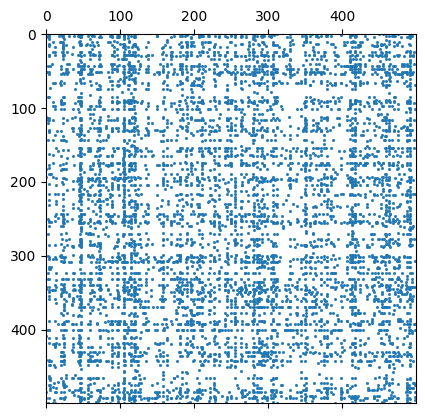

In [17]:
import matplotlib.pyplot as plt
plt.spy(train_user_item_sparse[:500, :500], markersize=1)
plt.show()


In [18]:
import numpy as np

def matrix_stats(M):


    print(f"Dimensões (usuários x itens): {M.shape}")
    print(f"Número total de elementos: {M.shape[0] * M.shape[1]:,}")
    
    # Elementos não nulos
    nnz = M.nnz

    # Densidade / Sparsidade
    density = nnz / (M.shape[0] * M.shape[1])
    print(f"Densidade: {density:.6f}")
    print(f"Esparsidade: {1 - density:.6f}")


    print(f"Média dos ratings: {M.data.mean():.2f}")


# Chamada:
matrix_stats(train_user_item_sparse)


Dimensões (usuários x itens): (666, 1533)
Número total de elementos: 1,020,978
Densidade: 0.024242
Esparsidade: 0.975758
Média dos ratings: 1.00


## Treinamento Modelo

#### EASEr (Embarrassingly Shallow Autoencoders)

##### Treino Base

In [ ]:


import numpy as np

class EASE:
    def __init__(self):
        pass

    def fit(self, X, lambda_):
        """
        X: sparse matrix (users × items)
        lambda_: regularization
        """
        self.X = X
        G = (X.T @ X).toarray()

        diag = np.diag_indices(G.shape[0])
        G[diag] += lambda_

        P = np.linalg.inv(G)
        B = P / (-np.diag(P))
        B[diag] = 0

        self.B = B
        self.pred = X @ B

        

    # def recommend(self, user, k=10):
    #     """
    #     user: índice inteiro
    #     retorna: top-k itens não consumidos
    #     """
    #     user_row = self.X[user].toarray().ravel()
    #     scores = self.pred[user]

    #     watched = np.where(user_row > 0)[0]
    #     scores[watched] = -np.inf

    #     topk = np.argpartition(scores, -k)[-k:]
    #     topk = topk[np.argsort(scores[topk])[::-1]]

    #     return topk, scores[topk]


In [20]:
ease = EASE()
ease.fit(train_user_item_sparse, lambda_=500)

import numpy as np

def recommend_user(ease, user, k=10):
    # scores previstos para todos os itens
    scores = ease.pred[user].copy()

    # remover itens que o usuário já consumiu
    user_interactions = ease.X[user].toarray().ravel()
    scores[user_interactions > 0] = -np.inf

    # pegar top-k
    topk = np.argpartition(scores, -k)[-k:]
    topk = topk[np.argsort(scores[topk])[::-1]]  # ordenar

    return topk, scores[topk]


items, scores = recommend_user(ease, user=0, k=10)
print(items)
print(scores)

[1247 1501  969  541  824  717 1074  670  727 1219]
[0.43090731 0.42032797 0.34580196 0.33807357 0.32529713 0.31296057
 0.31174011 0.29654913 0.28676067 0.2846967 ]


##### Teste

In [52]:
import numpy as np
from tqdm import tqdm
from numpy import log2

def avaliar_crag_completo(dataset, ease_model, movie_mapper, k_values=[5, 10, 15, 20, 50]):
    """
    Avaliação completa com Recall e NDCG para múltiplos K.
    
    PROTOCOLOS CRAG (PAPER-COMPLIANT): 
    1. Macro-Average: Média das métricas calculada por turno.
    2. Context Filtering: Apenas itens positivos/neutros entram no input.
    3. Masking: Itens vistos são mascarados com -inf na predição.
    4. Ground Truth: Sugestões do sistema, excluindo o que o usuário já viu.
    """
    
    # 1. Preparação da Matriz de Pesos (Replicando model.py)
    # Zera a diagonal para evitar que o item recomende a si mesmo
    W = ease_model.B.copy()
    np.fill_diagonal(W, 0)
    n_items = W.shape[0]
    
    # Inicializa dicionário de resultados
    results = {k: {'recalls': [], 'ndcgs': []} for k in k_values}
    
    # Loop principal por conversas
    for conv in tqdm(dataset, desc="CRAG Full Eval"):
        seeker_id = conv.get("initiatorWorkerId") # usuario
        recommender_id = conv.get("respondentWorkerId")
        
        # Carrega metadados de forma segura
        init_q = conv.get("initiatorQuestions", {})
        if isinstance(init_q, list): init_q = {}
        
        rq = conv.get("respondentQuestions", {})
        if isinstance(rq, list): rq = {}
        
        mentions = conv.get("movieMentions", {})
        if not mentions: continue
        
        mention_keys = list(mentions.keys())
        
        # 2. Reconstrução da Timeline (Turno a Turno)
        timeline = []
        for msg in conv.get("messages", []): #mensagem
            text = msg.get("text", "") # texto da msg
            ids_in_msg = [int(mid) for mid in mention_keys if f"@{mid}" in text] #id dos filmes 
            
            if ids_in_msg:
                sender = msg.get("senderWorkerId")
                timeline.append({
                    "ids": ids_in_msg,
                    "is_rec": (sender == recommender_id), # Turno do Sistema
                    "is_seek": (sender == seeker_id)      # Turno do Usuário
                })
        
        context_pool = set() # Itens para Input (Vetor do Usuário)
        seen_pool = set()    # Histórico Total (Para remover do alvo)
        
        for step in timeline:
            step_ids = step["ids"]
            
            # 3. Avaliação do Turno do Sistema (Recomendação)
            if step["is_rec"]:
                targets = []
                
                # Definição de Ground Truth (conforme evaluate.py & metrics.py)
                for mid in step_ids:
                    # Só conta se foi uma sugestão explícita do sistema
                    resp_flags = rq.get(str(mid), {})
                    if resp_flags.get("suggested") != 1:
                        continue
                    
                    # Filtro de Novidade (metrics.py: remove_seen)
                    # Exclui se o usuário marcou explicitamente como 'seen' (visto antes)
                    init_flags = init_q.get(str(mid), {})
                    if init_flags.get('seen') != 0: 
                        continue
                    
                    # Exclui se já apareceu na conversa atual (seen_pool) ou se não temos no treino
                    if mid in seen_pool or mid not in movie_mapper:
                        continue
                    
                    targets.append(mid)
                
                # Só roda inferência se houver alvos (Ground Truth) E contexto válido
                if targets and context_pool:
                    input_indices = [movie_mapper[mid] for mid in context_pool if mid in movie_mapper]
                    
                    if input_indices:
                        # Inferência EASE (Cálculo Matricial)
                        user_vector = np.zeros(n_items, dtype=np.float32)
                        user_vector[input_indices] = 1.0
                        scores = user_vector @ W
                        
                        # Mascaramento (Masking): Proíbe recomendar o que já foi visto
                        seen_indices = [movie_mapper[mid] for mid in seen_pool if mid in movie_mapper]
                        if seen_indices:
                            scores[seen_indices] = -np.inf
                        
                        # OTIMIZAÇÃO: Ordena apenas uma vez para o maior K necessário
                        max_k = max(k_values)
                        
                        # 1. Pega os índices dos top-max_k (desordenados) - Rápido
                        top_indices_unordered = np.argpartition(scores, -max_k)[-max_k:]
                        
                        # 2. Ordena apenas esses top-max_k scores - Rápido
                        top_scores = scores[top_indices_unordered]
                        sorted_idx_local = np.argsort(top_scores)[::-1]
                        top_k_sorted_all = top_indices_unordered[sorted_idx_local]
                        
                        # Calcula métricas para todos os K solicitados fatiando a lista ordenada
                        for k in k_values:
                            top_k_indices = top_k_sorted_all[:k]
                            top_k_set = set(top_k_indices)
                            
                            # Cálculo de Recall
                            hits = sum(1 for t in targets if movie_mapper[t] in top_k_set)
                            recall_val = hits / len(targets)
                            results[k]['recalls'].append(recall_val)
                            
                            # Cálculo de NDCG
                            dcg = 0.0
                            for rank, item_idx in enumerate(top_k_indices):
                                for t in targets:
                                    if movie_mapper[t] == item_idx:
                                        dcg += 1.0 / log2(rank + 2)
                                        break
                            
                            ideal_k = min(len(targets), k)
                            idcg = sum(1.0 / log2(i + 2) for i in range(ideal_k))
                            ndcg = dcg / idcg if idcg > 0 else 0.0
                            results[k]['ndcgs'].append(ndcg)
            
            # 4. Atualização dos Pools
            seen_pool.update(step_ids)
            
            if step["is_seek"]:
                for mid in step_ids:
                    # Filtro de Contexto (evaluate.py): Remove itens com dislike explícito
                    if str(mid) in init_q and init_q[str(mid)].get('liked') == 0:
                        continue
                    context_pool.add(mid)
    
    # 5. Relatório Final
    print("\n" + "="*80)
    print("📊 CRAG OFFLINE - EASE BASELINE (PAPER EXACT - MULTI K)")
    print("="*80)
    
    # Cabeçalho dinâmico
    header = f"{'Metric':<12}" + "".join([f"K={k:<10}" for k in k_values])
    print(header)
    print("-" * 80)
    
    final_recalls = [np.mean(results[k]['recalls']) for k in k_values]
    final_ndcgs = [np.mean(results[k]['ndcgs']) for k in k_values]
    
    row_rec = f"{'Recall':<12}" + "".join([f"{val:<10.4f}" for val in final_recalls])
    row_ndcg = f"{'NDCG':<12}" + "".join([f"{val:<10.4f}" for val in final_ndcgs])
    
    print(row_rec)
    print(row_ndcg)
    print(f"\n✅ Total de Turnos Avaliados: {len(results[k_values[0]]['recalls'])}")
    print("="*80)
    
    # Comparativo Rápido com Paper
    print("\n📌 Benchmark (Aprox. Fig 6b do Paper):")
    print("   R@10 ≈ 0.11  |  R@20 ≈ 0.15")
    print("   N@10 ≈ 0.06  |  N@20 ≈ 0.08")
    
    return results

results = avaliar_crag_completo(test_data, ease, movie_mapper, k_values=[1, 5, 10, 15, 20, 50])

CRAG Full Eval:   0%|          | 0/1342 [00:00<?, ?it/s]

CRAG Full Eval: 100%|██████████| 1342/1342 [00:03<00:00, 395.85it/s]


📊 CRAG OFFLINE - EASE BASELINE (PAPER EXACT - MULTI K)
Metric      K=1         K=5         K=10        K=15        K=20        K=50        
--------------------------------------------------------------------------------
Recall      0.0344    0.0769    0.1095    0.1297    0.1415    0.2284    
NDCG        0.0361    0.0573    0.0682    0.0737    0.0766    0.0942    

✅ Total de Turnos Avaliados: 915

📌 Benchmark (Aprox. Fig 6b do Paper):
   R@10 ≈ 0.11  |  R@20 ≈ 0.15
   N@10 ≈ 0.06  |  N@20 ≈ 0.08


##### Teste funcionamento


In [22]:
# --- 1. CRIAR MAPA DE TÍTULOS (Necessário para humanos entenderem) ---
def build_title_mappers(dataset):
    id_to_title = {}
    title_to_id = {}
    
    for conv in dataset:
        mentions = conv.get("movieMentions", {})
        for m_id, m_title in mentions.items():
            try:
                m_id = int(m_id)
                # Limpeza simples no título
                title_clean = m_title.strip()  
                
                id_to_title[m_id] = title_clean
                title_to_id[title_clean.lower()] = m_id # Lowercase para facilitar busca
            except:
                continue
                
    return id_to_title, title_to_id

print("Criando mapa de títulos...")
id_to_title, title_to_id = build_title_mappers(train_data)
print(f"Mapeados {len(id_to_title)} filmes com títulos.")

import numpy as np

def simular_recomendacao(model, movie_name, k=5):
    # 1. Normaliza o input para busca
    search_key = movie_name.lower().strip()
    
    # Tenta achar ID
    target_id = title_to_id.get(search_key)
    if target_id is None:
        # Busca parcial
        possible = [t for t in title_to_id.keys() if search_key in t]
        if possible:
            target_id = title_to_id[possible[0]]
            print(f"🔎 Filme input interpretado como: '{id_to_title[target_id]}'")
        else:
            return [f"Filme '{movie_name}' não encontrado."]

    if target_id not in movie_mapper:
        return ["Filme removido na filtragem."]
    
    matrix_idx = movie_mapper[target_id]
    
    # 2. Pega os Scores
    scores = model.B[matrix_idx].copy()
    
    # 3. Mascara o ID exato (Obrigatório)
    scores[matrix_idx] = -np.inf
    
    # 4. Ordena tudo (Top 2*k para ter margem de descarte)
    top_indices = np.argpartition(scores, -(k*2))[-(k*2):]
    top_indices = top_indices[np.argsort(scores[top_indices])[::-1]]
    
    recommendations = []
    
    # Mapa reverso para traduzir ID -> Nome
    index_to_movie_id = {v: k for k, v in movie_mapper.items()}
    
    # 5. LOOP DE FILTRAGEM DE DUPLICATAS
    input_title_clean = id_to_title[target_id].lower().replace("the ", "").split("(")[0].strip()
    
    count = 0
    for idx in top_indices:
        if count >= k: break # Já temos recomendações suficientes
        
        real_id = index_to_movie_id[idx]
        title_full = id_to_title.get(real_id, "")
        
        # Limpeza do título candidato para comparação
        candidate_clean = title_full.lower().replace("the ", "").split("(")[0].strip()
        
        # --- A CORREÇÃO MÁGICA ---
        # Se o nome do candidato for igual ao input (ex: "Matrix" == "Matrix"), PULA.
        if input_title_clean == candidate_clean:
            continue
            
        recommendations.append((title_full, scores[idx]))
        count += 1
        
    return recommendations

def simular_com_recall(model, movie_name, expected_list, k=10):
    """
    Simula a recomendação e calcula o Recall baseado numa lista de filmes esperados.
    """
    # 1. Gera as recomendações (usando a função corrigida anterior)
    # Nota: A função retorna tuplas (nome, score)
    recs_com_score = simular_recomendacao(model, movie_name, k=k)
    
    # Extrai apenas os nomes dos recomendados (normalizando para comparação)
    rec_names_clean = [r[0].lower().strip() for r in recs_com_score]
    
    # 2. Processa o Gabarito (Expected List)
    expected_clean = [e.lower().strip() for e in expected_list]
    
    # 3. Calcula os Acertos (Hits)
    hits = []
    for exp in expected_clean:
        # Verifica se o esperado está em ALGUMA das recomendações (busca parcial/fuzzy ajuda aqui)
        # Se quiser match exato: if exp in rec_names_clean:
        match = any(exp in rec for rec in rec_names_clean) 
        if match:
            hits.append(exp)
            
    # 4. Cálculo do Recall
    # Recall = (Itens Relevantes Recuperados) / (Total de Itens Relevantes)
    if len(expected_list) == 0:
        recall = 0.0
    else:
        recall = len(hits) / len(expected_list)
        
    # --- VISUALIZAÇÃO ---
    print(f"\n🎬 Input: '{movie_name}'")
    print(f"📋 Gabarito (Esperados): {expected_list}")
    print(f"📊 Recall@{k}: {recall:.2%} ({len(hits)}/{len(expected_list)})")
    print("-" * 30)
    print("💡 Recomendações do Modelo:")
    
    for i, (name, score) in enumerate(recs_com_score):
        # Marca com um ✅ se foi um Hit
        name_clean = name.lower().strip()
        is_hit = any(exp in name_clean for exp in expected_clean)
        mark = "✅" if is_hit else "  "
        print(f"{mark} {i+1}. {name} (Score: {score:.4f})")
        
    return recall

Criando mapa de títulos...
Mapeados 6222 filmes com títulos.


In [23]:
# Teste 1: Clássico Sci-Fi
filme_input = "The Matrix"
recs = simular_recomendacao(ease, filme_input)

print(f"\n🤖 Usuário: Gostei de '{filme_input}'")
print(f"💡 EASE Recomenda:")
for i, (name, score) in enumerate(recs):
    print(f"   {i+1}. {name} (Score: {score:.4f})")

# Teste 2: Terror
filme_input = "The Shining"
recs = simular_recomendacao(ease, filme_input)

print(f"\n🤖 Usuário: Gostei de '{filme_input}'")
print(f"💡 EASE Recomenda:")
for i, (name, score) in enumerate(recs):
    print(f"   {i+1}. {name} (Score: {score:.4f})")

# Teste 3: Romance/Drama
filme_input = "The Notebook"
recs = simular_recomendacao(ease, filme_input)

print(f"\n🤖 Usuário: Gostei de '{filme_input}'")
print(f"💡 EASE Recomenda:")
for i, (name, score) in enumerate(recs):
    print(f"   {i+1}. {name} (Score: {score:.4f})")


🤖 Usuário: Gostei de 'The Matrix'
💡 EASE Recomenda:


ValueError: too many values to unpack (expected 2)

In [ ]:
# Teste: Matrix
# Eu (humano) digo que quem vê Matrix deveria ver estes 3:
gabarito_matrix = ["Inception", "Dark City", "Blade Runner"]

simular_com_recall(ease, "The Matrix", gabarito_matrix, k=20)


🎬 Input: 'The Matrix'
📋 Gabarito (Esperados): ['Inception', 'Dark City', 'Blade Runner']
📊 Recall@20: 0.00% (0/3)
------------------------------
💡 Recomendações do Modelo:
   1. Office Space (1999) (Score: 0.0063)
   2. The Avengers  (2012) (Score: 0.0061)
   3. Jurassic Park  (1993) (Score: 0.0057)
   4. Suicide Squad  (2016) (Score: 0.0057)
   5. Fast & Furious  (2009) (Score: 0.0053)
   6. Spider-Man: Homecoming (2017) (Score: 0.0053)
   7. Ant-Man  (2015) (Score: 0.0052)
   8. A Nightmare on Elm Street (1984) (Score: 0.0052)
   9. Spider-Man  (2002) (Score: 0.0049)
   10. Hot Fuzz (2007) (Score: 0.0047)
   11. Batman Begins (Score: 0.0045)
   12. Batman  (1989) (Score: 0.0044)
   13. Kingsman: The Golden Circle (Score: 0.0042)
   14. Bright (2017) (Score: 0.0042)
   15. Avengers: Infinity War (2018) (Score: 0.0041)
   16. Fight Club (1999) (Score: 0.0041)
   17. Young Frankenstein (1974) (Score: 0.0041)
   18. John Wick: Chapter 2 (2017) (Score: 0.0040)
   19. I Know What You Did 

0.0

In [ ]:
def obter_gabarito_do_dataset(movie_name, top_n_gabarito=5):
    """
    Olha no dataset de treino e encontra os filmes que mais co-ocorrem com o input.
    Isso serve como 'Ground Truth' baseado em dados.
    """
    # 1. Achar ID do filme
    search_key = movie_name.lower().strip()
    target_id = title_to_id.get(search_key)
    
    if target_id is None:
        # Tenta parcial
        possible = [t for t in title_to_id.keys() if search_key in t]
        if possible: target_id = title_to_id[possible[0]]
        else: return []

    # 2. Achar a coluna desse filme na matriz esparsa
    if target_id not in movie_mapper: return []
    col_idx = movie_mapper[target_id]
    
    # 3. Quem viu esse filme? (Linhas da matriz onde valor > 0)
    # train_user_item_sparse é a sua matriz (Users x Items)
    users_who_saw = train_user_item_sparse[:, col_idx].nonzero()[0]
    
    if len(users_who_saw) == 0: return []
    
    # 4. O que MAIS essas pessoas viram?
    # Somamos as linhas desses usuários
    co_occurrences = np.array(train_user_item_sparse[users_who_saw, :].sum(axis=0)).flatten()
    
    # Zera o próprio filme (não queremos contar ele mesmo)
    co_occurrences[col_idx] = 0
    
    # 5. Pegar os Top-N mais frequentes
    top_indices = np.argpartition(co_occurrences, -top_n_gabarito)[-top_n_gabarito:]
    
    gabarito_names = []
    index_to_movie_id = {v: k for k, v in movie_mapper.items()}
    
    for idx in top_indices:
        real_id = index_to_movie_id[idx]
        title = id_to_title.get(real_id, str(real_id))
        count = co_occurrences[idx]
        if count > 0: # Só adiciona se teve co-ocorrência real
            gabarito_names.append(title)
            
    return gabarito_names

# --- EXECUÇÃO FINAL ---

movie_input = "The Godfather"

# 1. O sistema descobre o que DEVERIA recomendar baseado na estatística do dataset
gabarito_dados = obter_gabarito_do_dataset(movie_input, top_n_gabarito=5)

# 2. O sistema simula e calcula o Recall sobre esse gabarito
simular_com_recall(ease, movie_input, gabarito_dados, k=10)


🎬 Input: 'The Godfather'
📋 Gabarito (Esperados): ['Saw  (2004)', 'A Nightmare on Elm Street (1984)', 'The Matrix (1999)', 'It  (2017)', 'Black Panther (2018)']
📊 Recall@10: 100.00% (5/5)
------------------------------
💡 Recomendações do Modelo:
✅ 1. The Matrix (1999) (Score: 0.0079)
✅ 2. Black Panther (2018) (Score: 0.0076)
✅ 3. A Nightmare on Elm Street (1984) (Score: 0.0064)
   4. Caddyshack (1980) (Score: 0.0060)
   5. Grease  (1978) (Score: 0.0059)
✅ 6. Saw  (2004) (Score: 0.0057)
   7. Scarface  (1983) (Score: 0.0054)
✅ 8. It  (2017) (Score: 0.0054)
   9. Goodfellas (1990) (Score: 0.0053)
   10. The Princess Bride  (1987) (Score: 0.0050)


1.0

#### ALS (Alternating Least Squares)

In [30]:
from implicit.als import AlternatingLeastSquares

als_model = AlternatingLeastSquares( 
    factors=32,
    regularization=0.1,
    alpha=20,           # essencial!
    iterations=30,
    random_state=42
)


# Importante: implicit espera matriz item x user (transposta!)
als_model.fit(train_item_user_sparse)

print("user factors:", als_model.user_factors.shape)
print("item factors:", als_model.item_factors.shape)



100%|██████████| 30/30 [00:00<00:00, 180.72it/s]

user factors: (1533, 32)
item factors: (666, 32)


In [47]:
import numpy as np
from tqdm import tqdm
from numpy import log2
from scipy.sparse import csr_matrix

def avaliar_crag_als(dataset, als_model, movie_mapper, k_values=[5, 10, 15, 20, 50]):
    """
    Avaliação CRAG para modelos ALS (biblioteca 'implicit').
    Com proteção contra índices fora do limite do modelo.
    """
    
    # Pega o número real de itens que o modelo conhece
    model_n_items = als_model.item_factors.shape[0]

    results = {k: {'recalls': [], 'ndcgs': []} for k in k_values}
    max_k = max(k_values)
    
    for conv in tqdm(dataset, desc="CRAG Full Eval (ALS)"):
        seeker_id = conv.get("initiatorWorkerId")
        recommender_id = conv.get("respondentWorkerId")
        
        init_q = conv.get("initiatorQuestions", {})
        if isinstance(init_q, list): init_q = {}
        
        rq = conv.get("respondentQuestions", {})
        if isinstance(rq, list): rq = {}
        
        mentions = conv.get("movieMentions", {})
        if not mentions: continue
        
        mention_keys = list(mentions.keys())
        
        timeline = []
        for msg in conv.get("messages", []):
            text = msg.get("text", "")
            ids_in_msg = [int(mid) for mid in mention_keys if f"@{mid}" in text]
            if ids_in_msg:
                sender = msg.get("senderWorkerId")
                timeline.append({
                    "ids": ids_in_msg,
                    "is_rec": (sender == recommender_id),
                    "is_seek": (sender == seeker_id)
                })
        
        context_pool = set()
        seen_pool = set()
        
        for step in timeline:
            step_ids = step["ids"]
            
            if step["is_rec"]:
                targets = []
                for mid in step_ids:
                    resp_flags = rq.get(str(mid), {})
                    if resp_flags.get("suggested") != 1: continue
                    
                    init_flags = init_q.get(str(mid), {})
                    if init_flags.get('seen') != 0: continue
                    
                    if mid in seen_pool or mid not in movie_mapper: continue
                    targets.append(mid)
                
                if targets and context_pool:
                    # 1. Pega índices mapeados
                    raw_indices = [movie_mapper[mid] for mid in context_pool if mid in movie_mapper]
                    
                    # 2. FILTRAGEM DE SEGURANÇA (A Correção)
                    # Só mantém índices que cabem na matriz do modelo
                    input_indices = [idx for idx in raw_indices if idx < model_n_items]
                    
                    if input_indices:
                        data = np.ones(len(input_indices), dtype=np.float32)
                        rows = np.zeros(len(input_indices), dtype=np.int32)
                        cols = np.array(input_indices, dtype=np.int32)
                        
                        # Cria matriz com o tamanho EXATO do modelo
                        user_sparse = csr_matrix((data, (rows, cols)), shape=(1, model_n_items))
                        
                        limit = max_k + len(seen_pool) + 20
                        
                        try:
                            rec_ids, rec_scores = als_model.recommend(
                                userid=0, 
                                user_items=user_sparse, 
                                N=limit, 
                                filter_already_liked_items=False, 
                                recalculate_user=True 
                            )
                        except ValueError:
                            continue
                        
                        # Mascaramento
                        top_k_cleaned = []
                        seen_indices = {movie_mapper[mid] for mid in seen_pool if mid in movie_mapper}
                        
                        for idx in rec_ids:
                            if idx not in seen_indices:
                                top_k_cleaned.append(idx)
                                if len(top_k_cleaned) == max_k:
                                    break
                        
                        # Métricas
                        for k in k_values:
                            current_top_k = top_k_cleaned[:k]
                            current_top_set = set(current_top_k)
                            
                            hits = sum(1 for t in targets if movie_mapper[t] in current_top_set)
                            results[k]['recalls'].append(hits / len(targets))
                            
                            dcg = 0.0
                            for rank, item_idx in enumerate(current_top_k):
                                for t in targets:
                                    if movie_mapper[t] == item_idx:
                                        dcg += 1.0 / log2(rank + 2)
                                        break
                            ideal_k = min(len(targets), k)
                            idcg = sum(1.0 / log2(i + 2) for i in range(ideal_k))
                            ndcg = dcg / idcg if idcg > 0 else 0.0
                            results[k]['ndcgs'].append(ndcg)

            seen_pool.update(step_ids)
            if step["is_seek"]:
                for mid in step_ids:
                    if str(mid) in init_q and init_q[str(mid)].get('liked') == 0: continue
                    context_pool.add(mid)

    print("\n" + "="*80)
    print("📊 CRAG OFFLINE - ALS MODEL (FIXED)")
    print("="*80)
    
    header = f"{'Metric':<12}" + "".join([f"K={k:<10}" for k in k_values])
    print(header)
    print("-" * 80)
    
    final_recalls = [np.mean(results[k]['recalls']) for k in k_values]
    final_ndcgs = [np.mean(results[k]['ndcgs']) for k in k_values]
    
    print(f"{'Recall':<12}" + "".join([f"{val:<10.4f}" for val in final_recalls]))
    print(f"{'NDCG':<12}" + "".join([f"{val:<10.4f}" for val in final_ndcgs]))
    print("="*80)
    
    return results


als_model = AlternatingLeastSquares( 
    factors=64,
    regularization=0.1,
    alpha=40,           # essencial!
    iterations=20,
    random_state=42
)


# Importante: implicit espera matriz item x user (transposta!)
als_model.fit(train_user_item_sparse)

results_als = avaliar_crag_als(
    test_data, 
    als_model, # Seu modelo treinado (implicit.als.AlternatingLeastSquares)
    movie_mapper, 
    k_values=[5, 10, 20]
)

CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 2322.75it/s]


📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=5         K=10        K=20        
--------------------------------------------------------------------------------
Recall      0.0701    0.1138    0.1525    
NDCG        0.0490    0.0633    0.0732    


In [ ]:
import pandas as pd
import numpy as np
import implicit
from itertools import product
import time

# --- CONFIGURAÇÃO DO GRID ---
# Aqui estão os "mais valores" que você pediu:
param_grid = {
    'factors': [32, 64, 128],        # Tamanho do vetor latente
    'alpha': [15, 40, 80],           # Confiança no dado positivo (Importante!)
    'regularization': [0.01, 0.1, 0.5] # Força da penalidade (0.01 é padrão, 0.5 é forte)
}

# Gera todas as combinações possíveis (3 x 3 x 3 = 27 modelos)
combinations = list(product(
    param_grid['factors'], 
    param_grid['alpha'], 
    param_grid['regularization']
))

print(f"🚀 Iniciando Grid Search com {len(combinations)} combinações...")
print("-" * 60)

results_log = []
best_recall = -1
best_params = None

# Loop Principal
for idx, (fac, alp, reg) in enumerate(combinations):
    
    start_time = time.time()
    
    # 1. Instancia o Modelo
    model = implicit.als.AlternatingLeastSquares(
        factors=fac,
        regularization=reg,
        alpha=alp,
        iterations=20,       # 20 é suficiente para convergir
        random_state=42,
        calculate_training_loss=False
    )
    
    # 2. Treina (Lembre-se: USER x ITEM)
    # Suprime output do tqdm do implicit para não poluir
    model.fit(train_user_item_sparse, show_progress=False)
    
    # 3. Avalia
    # Usamos apenas K=20 para decisão rápida (métrica principal)
    # Passamos n_items explicitamente para evitar erros de índice
    eval_res = avaliar_crag_als(
        dataset=test_data, 
        als_model=model, 
        movie_mapper=movie_mapper,
        k_values=[20] 
    )
    
    # 4. Coleta Métricas
    recall_20 = np.mean(eval_res[20]['recalls'])
    ndcg_20 = np.mean(eval_res[20]['ndcgs'])
    elapsed = time.time() - start_time
    
    print(f"✅ R@20: {recall_20:.4f} | Tempo: {elapsed:.1f}s")
    
    # Salva log
    results_log.append({
        'factors': fac,
        'alpha': alp,
        'reg': reg,
        'Recall@20': recall_20,
        'NDCG@20': ndcg_20
    })
    
    # Atualiza o campeão
    if recall_20 > best_recall:
        best_recall = recall_20
        best_params = {'factors': fac, 'alpha': alp, 'reg': reg}

# --- RELATÓRIO FINAL ---
print("\n" + "="*60)
print("🏆 MELHOR CONFIGURAÇÃO ENCONTRADA")
print("="*60)
print(f"Parâmetros: {best_params}")
print(f"Recall@20:  {best_recall:.4f}")
print("-" * 60)

# Mostra Top 5 Melhores
df_results = pd.DataFrame(results_log)
df_results = df_results.sort_values(by='Recall@20', ascending=False)

print("\n📊 Top 5 Melhores Modelos:")
print(df_results.head(5).to_string(index=False))

🚀 Iniciando Grid Search com 144 combinações...
------------------------------------------------------------


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 2606.30it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1319    
NDCG        0.0626    
✅ R@20: 0.1319 | Tempo: 0.6s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 3068.65it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1332    
NDCG        0.0601    
✅ R@20: 0.1332 | Tempo: 0.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 2832.19it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1348    
NDCG        0.0618    
✅ R@20: 0.1348 | Tempo: 0.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 2909.29it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1352    
NDCG        0.0636    
✅ R@20: 0.1352 | Tempo: 0.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1769.87it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1332    
NDCG        0.0609    
✅ R@20: 0.1332 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1781.22it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1310    
NDCG        0.0622    
✅ R@20: 0.1310 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1881.52it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1412    
NDCG        0.0654    
✅ R@20: 0.1412 | Tempo: 1.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1840.29it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1472    
NDCG        0.0673    
✅ R@20: 0.1472 | Tempo: 1.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1739.39it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1332    
NDCG        0.0660    
✅ R@20: 0.1332 | Tempo: 1.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1570.35it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1477    
NDCG        0.0688    
✅ R@20: 0.1477 | Tempo: 2.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1479.03it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1490    
NDCG        0.0717    
✅ R@20: 0.1490 | Tempo: 2.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1364.59it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1512    
NDCG        0.0683    
✅ R@20: 0.1512 | Tempo: 2.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1414.89it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1293    
NDCG        0.0551    
✅ R@20: 0.1293 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1775.48it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1271    
NDCG        0.0559    
✅ R@20: 0.1271 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1435.98it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1299    
NDCG        0.0563    
✅ R@20: 0.1299 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1489.53it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1291    
NDCG        0.0564    
✅ R@20: 0.1291 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1931.90it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1342    
NDCG        0.0598    
✅ R@20: 0.1342 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1957.88it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1370    
NDCG        0.0590    
✅ R@20: 0.1370 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1934.15it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1352    
NDCG        0.0602    
✅ R@20: 0.1352 | Tempo: 1.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1833.37it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1439    
NDCG        0.0662    
✅ R@20: 0.1439 | Tempo: 1.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1927.21it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1395    
NDCG        0.0615    
✅ R@20: 0.1395 | Tempo: 1.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1638.50it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1264    
NDCG        0.0561    
✅ R@20: 0.1264 | Tempo: 2.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1932.80it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1428    
NDCG        0.0648    
✅ R@20: 0.1428 | Tempo: 1.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1848.74it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1472    
NDCG        0.0648    
✅ R@20: 0.1472 | Tempo: 1.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1935.73it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1109    
NDCG        0.0510    
✅ R@20: 0.1109 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1740.03it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1175    
NDCG        0.0532    
✅ R@20: 0.1175 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1966.68it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1244    
NDCG        0.0519    
✅ R@20: 0.1244 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1934.41it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1113    
NDCG        0.0519    
✅ R@20: 0.1113 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1902.57it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1233    
NDCG        0.0551    
✅ R@20: 0.1233 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1937.28it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1260    
NDCG        0.0524    
✅ R@20: 0.1260 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1875.00it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1171    
NDCG        0.0553    
✅ R@20: 0.1171 | Tempo: 1.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1837.41it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1242    
NDCG        0.0590    
✅ R@20: 0.1242 | Tempo: 1.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1896.22it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1332    
NDCG        0.0576    
✅ R@20: 0.1332 | Tempo: 1.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1706.59it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1346    
NDCG        0.0599    
✅ R@20: 0.1346 | Tempo: 1.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1902.00it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1188    
NDCG        0.0514    
✅ R@20: 0.1188 | Tempo: 1.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1914.89it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1430    
NDCG        0.0601    
✅ R@20: 0.1430 | Tempo: 1.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1883.34it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1109    
NDCG        0.0511    
✅ R@20: 0.1109 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1907.47it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1104    
NDCG        0.0524    
✅ R@20: 0.1104 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1757.67it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1184    
NDCG        0.0525    
✅ R@20: 0.1184 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1993.37it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1071    
NDCG        0.0496    
✅ R@20: 0.1071 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1946.13it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1118    
NDCG        0.0528    
✅ R@20: 0.1118 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1860.48it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1173    
NDCG        0.0512    
✅ R@20: 0.1173 | Tempo: 0.8s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1860.52it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1264    
NDCG        0.0546    
✅ R@20: 0.1264 | Tempo: 1.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1881.47it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1266    
NDCG        0.0556    
✅ R@20: 0.1266 | Tempo: 1.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1860.79it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1233    
NDCG        0.0543    
✅ R@20: 0.1233 | Tempo: 1.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1925.93it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1188    
NDCG        0.0517    
✅ R@20: 0.1188 | Tempo: 1.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1823.65it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1255    
NDCG        0.0528    
✅ R@20: 0.1255 | Tempo: 1.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1914.87it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1250    
NDCG        0.0566    
✅ R@20: 0.1250 | Tempo: 2.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1811.18it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1421    
NDCG        0.0730    
✅ R@20: 0.1421 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1752.47it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1514    
NDCG        0.0744    
✅ R@20: 0.1514 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1407.89it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1486    
NDCG        0.0757    
✅ R@20: 0.1486 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1809.44it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1393    
NDCG        0.0738    
✅ R@20: 0.1393 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1811.51it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1459    
NDCG        0.0738    
✅ R@20: 0.1459 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1780.56it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1426    
NDCG        0.0747    
✅ R@20: 0.1426 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1710.16it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1446    
NDCG        0.0752    
✅ R@20: 0.1446 | Tempo: 1.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1777.91it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1415    
NDCG        0.0725    
✅ R@20: 0.1415 | Tempo: 1.6s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1700.71it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1415    
NDCG        0.0719    
✅ R@20: 0.1415 | Tempo: 1.6s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1755.04it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1408    
NDCG        0.0734    
✅ R@20: 0.1408 | Tempo: 2.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1686.60it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1388    
NDCG        0.0734    
✅ R@20: 0.1388 | Tempo: 2.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1548.77it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1361    
NDCG        0.0699    
✅ R@20: 0.1361 | Tempo: 2.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1800.01it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1383    
NDCG        0.0682    
✅ R@20: 0.1383 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1708.01it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1492    
NDCG        0.0708    
✅ R@20: 0.1492 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1756.34it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1508    
NDCG        0.0742    
✅ R@20: 0.1508 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1801.67it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1459    
NDCG        0.0700    
✅ R@20: 0.1459 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1604.74it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1525    
NDCG        0.0732    
✅ R@20: 0.1525 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1742.66it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1519    
NDCG        0.0755    
✅ R@20: 0.1519 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1733.27it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1368    
NDCG        0.0701    
✅ R@20: 0.1368 | Tempo: 1.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1734.54it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1406    
NDCG        0.0730    
✅ R@20: 0.1406 | Tempo: 1.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1545.47it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1483    
NDCG        0.0746    
✅ R@20: 0.1483 | Tempo: 1.6s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1743.53it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1344    
NDCG        0.0709    
✅ R@20: 0.1344 | Tempo: 2.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1746.63it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1366    
NDCG        0.0693    
✅ R@20: 0.1366 | Tempo: 2.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1700.55it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1404    
NDCG        0.0702    
✅ R@20: 0.1404 | Tempo: 2.6s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1723.15it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1279    
NDCG        0.0651    
✅ R@20: 0.1279 | Tempo: 0.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1527.61it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1355    
NDCG        0.0692    
✅ R@20: 0.1355 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1698.27it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1372    
NDCG        0.0674    
✅ R@20: 0.1372 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1611.57it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1328    
NDCG        0.0673    
✅ R@20: 0.1328 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1737.79it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1419    
NDCG        0.0706    
✅ R@20: 0.1419 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1697.80it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1388    
NDCG        0.0683    
✅ R@20: 0.1388 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1676.80it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1346    
NDCG        0.0673    
✅ R@20: 0.1346 | Tempo: 1.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1725.27it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1423    
NDCG        0.0717    
✅ R@20: 0.1423 | Tempo: 1.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1741.12it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1461    
NDCG        0.0716    
✅ R@20: 0.1461 | Tempo: 1.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1728.73it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1344    
NDCG        0.0691    
✅ R@20: 0.1344 | Tempo: 2.6s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1674.86it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1430    
NDCG        0.0711    
✅ R@20: 0.1430 | Tempo: 2.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1698.21it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1395    
NDCG        0.0697    
✅ R@20: 0.1395 | Tempo: 2.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1404.20it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1220    
NDCG        0.0626    
✅ R@20: 0.1220 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1560.29it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1270    
NDCG        0.0662    
✅ R@20: 0.1270 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1626.21it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1324    
NDCG        0.0674    
✅ R@20: 0.1324 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1460.61it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1208    
NDCG        0.0646    
✅ R@20: 0.1208 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1647.26it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1368    
NDCG        0.0691    
✅ R@20: 0.1368 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1550.23it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1333    
NDCG        0.0672    
✅ R@20: 0.1333 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:01<00:00, 1186.94it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1377    
NDCG        0.0682    
✅ R@20: 0.1377 | Tempo: 2.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1720.03it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1417    
NDCG        0.0716    
✅ R@20: 0.1417 | Tempo: 1.6s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1780.35it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1415    
NDCG        0.0718    
✅ R@20: 0.1415 | Tempo: 1.6s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1745.27it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1295    
NDCG        0.0663    
✅ R@20: 0.1295 | Tempo: 2.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1731.60it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1386    
NDCG        0.0705    
✅ R@20: 0.1386 | Tempo: 2.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1744.78it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1410    
NDCG        0.0714    
✅ R@20: 0.1410 | Tempo: 2.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1408.16it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1228    
NDCG        0.0648    
✅ R@20: 0.1228 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1570.32it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1260    
NDCG        0.0646    
✅ R@20: 0.1260 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1546.76it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1242    
NDCG        0.0656    
✅ R@20: 0.1242 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1475.73it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1228    
NDCG        0.0652    
✅ R@20: 0.1228 | Tempo: 1.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1418.76it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1233    
NDCG        0.0651    
✅ R@20: 0.1233 | Tempo: 1.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1405.32it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1193    
NDCG        0.0639    
✅ R@20: 0.1193 | Tempo: 1.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:01<00:00, 1320.12it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1217    
NDCG        0.0671    
✅ R@20: 0.1217 | Tempo: 2.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1506.86it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1244    
NDCG        0.0675    
✅ R@20: 0.1244 | Tempo: 2.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1400.96it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1244    
NDCG        0.0679    
✅ R@20: 0.1244 | Tempo: 2.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1496.46it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1271    
NDCG        0.0688    
✅ R@20: 0.1271 | Tempo: 3.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1497.13it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1266    
NDCG        0.0684    
✅ R@20: 0.1266 | Tempo: 3.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1500.67it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1271    
NDCG        0.0685    
✅ R@20: 0.1271 | Tempo: 3.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1534.35it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1286    
NDCG        0.0664    
✅ R@20: 0.1286 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1541.80it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1304    
NDCG        0.0658    
✅ R@20: 0.1304 | Tempo: 1.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1490.34it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1321    
NDCG        0.0660    
✅ R@20: 0.1321 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1400.98it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1253    
NDCG        0.0654    
✅ R@20: 0.1253 | Tempo: 1.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1549.49it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1242    
NDCG        0.0641    
✅ R@20: 0.1242 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1526.91it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1250    
NDCG        0.0634    
✅ R@20: 0.1250 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1490.34it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1162    
NDCG        0.0637    
✅ R@20: 0.1162 | Tempo: 2.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1535.40it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1209    
NDCG        0.0647    
✅ R@20: 0.1209 | Tempo: 2.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1497.20it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1188    
NDCG        0.0641    
✅ R@20: 0.1188 | Tempo: 2.0s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1507.24it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1217    
NDCG        0.0658    
✅ R@20: 0.1217 | Tempo: 3.5s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1517.09it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1211    
NDCG        0.0660    
✅ R@20: 0.1211 | Tempo: 3.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1523.91it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1228    
NDCG        0.0666    
✅ R@20: 0.1228 | Tempo: 3.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1405.40it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1277    
NDCG        0.0645    
✅ R@20: 0.1277 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1375.56it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1179    
NDCG        0.0612    
✅ R@20: 0.1179 | Tempo: 1.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1413.17it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1271    
NDCG        0.0637    
✅ R@20: 0.1271 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:01<00:00, 1294.93it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1244    
NDCG        0.0647    
✅ R@20: 0.1244 | Tempo: 1.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1528.07it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1217    
NDCG        0.0632    
✅ R@20: 0.1217 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1491.19it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1282    
NDCG        0.0637    
✅ R@20: 0.1282 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1509.45it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1129    
NDCG        0.0609    
✅ R@20: 0.1129 | Tempo: 2.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1376.33it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1208    
NDCG        0.0627    
✅ R@20: 0.1208 | Tempo: 2.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1348.94it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1230    
NDCG        0.0635    
✅ R@20: 0.1230 | Tempo: 2.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1491.96it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1140    
NDCG        0.0634    
✅ R@20: 0.1140 | Tempo: 3.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:01<00:00, 1156.69it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1195    
NDCG        0.0646    
✅ R@20: 0.1195 | Tempo: 3.7s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1406.84it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1231    
NDCG        0.0645    
✅ R@20: 0.1231 | Tempo: 4.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:01<00:00, 1306.62it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1260    
NDCG        0.0634    
✅ R@20: 0.1260 | Tempo: 1.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:01<00:00, 1092.75it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1184    
NDCG        0.0620    
✅ R@20: 0.1184 | Tempo: 1.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:01<00:00, 1218.66it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1260    
NDCG        0.0624    
✅ R@20: 0.1260 | Tempo: 1.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1584.05it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1304    
NDCG        0.0648    
✅ R@20: 0.1304 | Tempo: 1.1s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1501.43it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1200    
NDCG        0.0616    
✅ R@20: 0.1200 | Tempo: 1.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1418.03it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1239    
NDCG        0.0627    
✅ R@20: 0.1239 | Tempo: 1.4s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1438.98it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1135    
NDCG        0.0608    
✅ R@20: 0.1135 | Tempo: 2.3s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1625.23it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1215    
NDCG        0.0631    
✅ R@20: 0.1215 | Tempo: 2.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:00<00:00, 1417.99it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1208    
NDCG        0.0639    
✅ R@20: 0.1208 | Tempo: 2.2s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:01<00:00, 1235.03it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1151    
NDCG        0.0623    
✅ R@20: 0.1151 | Tempo: 3.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:01<00:00, 1270.33it/s]



📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1217    
NDCG        0.0645    
✅ R@20: 0.1217 | Tempo: 3.9s


CRAG Full Eval (ALS): 100%|██████████| 1342/1342 [00:01<00:00, 911.74it/s]


📊 CRAG OFFLINE - ALS MODEL (FIXED)
Metric      K=20        
--------------------------------------------------------------------------------
Recall      0.1226    
NDCG        0.0641    
✅ R@20: 0.1226 | Tempo: 4.3s

🏆 MELHOR CONFIGURAÇÃO ENCONTRADA
Parâmetros: {'factors': 64, 'alpha': 40, 'iterations': 20, 'reg': 0.1}
Recall@20:  0.1525
------------------------------------------------------------

📊 Top 5 Melhores Modelos:
 factors  alpha  reg  Recall@20  NDCG@20
      64     40  0.1   0.152459 0.073198
      64     40  0.5   0.151913 0.075451
      64     15  0.1   0.151366 0.074397
      32     15  0.5   0.151184 0.068300
      64     40  0.5   0.150820 0.074193


#### BPR (Bayesian Personalized Ranking)

In [ ]:
from implicit.bpr import BayesianPersonalizedRanking

ModuleNotFoundError: No module named 'cornac'

In [ ]:

model = BayesianPersonalizedRanking( 
    factors=32,
    learning_rate = 0.001,
    regularization = 0.01,
    iterations=100,
    num_threads = 100,
    verify_negative_samples = True,
    random_state=42
)


# Importante: implicit espera matriz item x user (transposta!)
model.fit(train_item_user_sparse)



100%|██████████| 100/100 [00:00<00:00, 136.53it/s, train_auc=55.16%, skipped=23.59%]


In [ ]:
import numpy as np

def recall_at_k_single(model, train_item_user_sparse, test_matrix, user_internal, K=20):
    """Calcula o recall@K para UM usuário interno."""
    
    relevant_items = set(test_matrix[user_internal].indices)
    if len(relevant_items) == 0:
        return None  # usuário sem teste → ignorar

    # coluna item×user
    user_items_col = train_item_user_sparse.tocsr()[user_internal, :]

    rec_items, _ = model.recommend(
        user_internal,
        user_items_col,
        N=K,
        filter_already_liked_items=True
    )

    rec_set = set(rec_items)
    hits = rec_set & relevant_items

    recall = len(hits) / len(relevant_items)
    return recall


# ==============================
#  ENCONTRAR USUÁRIOS QUE TÊM TESTE
# ==============================
test_nonzero = test_user_item_sparse.getnnz(axis=1)
users_with_test_internal = np.where(test_nonzero > 0)[0]

print(f"Usuários com teste: {len(users_with_test_internal)}")


# ==============================
#  CALCULAR RECALL PARA TODOS
# ==============================
recalls = []
valid_users = []

for u in users_with_test_internal:
    r = recall_at_k_single(model, train_item_user_sparse, test_user_item_sparse, u, K=20)
    if r is not None:
        recalls.append(r)
        valid_users.append(u)

# ==============================
# ESTATÍSTICAS
# ==============================
recalls = np.array(recalls)

print("\n=========== MÉTRICAS GLOBAIS (Recall@20) ===========")
print(f"Usuários avaliados:            {len(recalls)}")
print(f"Recall médio:                  {recalls.mean():.4f}")
print(f"Recall mediano:                {np.median(recalls):.4f}")
print(f"Recall mínimo:                 {recalls.min():.4f}")
print(f"Recall máximo:                 {recalls.max():.4f}")
print(f"Usuários com recall > 0:       {np.sum(recalls > 0)}  ({100*np.mean(recalls>0):.1f}%)")
print("=====================================================\n")

# Opcional: mostrar os 10 melhores e piores
sorted_recalls = sorted(zip(valid_users, recalls), key=lambda x: x[1], reverse=True)

print("Top 10 maiores recalls:")
for u, r in sorted_recalls[:10]:
    print(f"user_internal={u}, recall={r:.4f}")

print("\nTop 10 menores recalls:")
for u, r in sorted_recalls[-10:]:
    print(f"user_internal={u}, recall={r:.4f}")



#0.0228
#0.0252     learning_rate = 0.001,


Usuários com teste: 142

=========== MÉTRICAS GLOBAIS (Recall@20) ===========
Usuários avaliados:            142
Recall médio:                  0.0253
Recall mediano:                0.0000
Recall mínimo:                 0.0000
Recall máximo:                 0.3333
Usuários com recall > 0:       50  (35.2%)

Top 10 maiores recalls:
user_internal=937, recall=0.3333
user_internal=969, recall=0.3333
user_internal=1013, recall=0.3333
user_internal=1021, recall=0.3333
user_internal=957, recall=0.2500
user_internal=1019, recall=0.2500
user_internal=1022, recall=0.2000
user_internal=1024, recall=0.1667
user_internal=897, recall=0.1250
user_internal=915, recall=0.1250

Top 10 menores recalls:
user_internal=1014, recall=0.0000
user_internal=1016, recall=0.0000
user_internal=1017, recall=0.0000
user_internal=1018, recall=0.0000
user_internal=1023, recall=0.0000
user_internal=1025, recall=0.0000
user_internal=1026, recall=0.0000
user_internal=1027, recall=0.0000
user_internal=1028, recall=0.0000
u

### Context Aware Revision

In [ ]:
import json
from openai import OpenAI

# Configure sua chave aqui
# client = OpenAI(api_key="SUA_CHAVE_AQUI")

def extract_movie_names_llm(user_text):
    """
    Passo 1: Recebe texto sujo, retorna lista limpa de nomes de filmes em Inglês.
    """
    prompt = f"""
    Pretend you are a specialist movie entity extractor for a recommender system. 
    You (a specialist movie entity extractor) will be given a full text a user sent 
    to you. Based on the entire text, you need to extract ALL movie names mentioned.

        YOUR JOB:
        Identify and extract ALL movies mentioned in the users text.
        
        RULES:
        1. Return ONLY a JSON. for example: {"movies": ["Movie A", "Movie B"]}
        2. Convert all movie titles to englisj=h (eg: "Cidade de Deus" -> "City of God").
        3. Correct minor and major spelling errors.
        4. If there are no movies mentioned, return {"movies": []}.

    Conversation:
    {user_text}

    """
        
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini", # Use mini para ser rápido e barato, ou gpt-4o para precisão
            messages=[
                {"role": "system", "content": prompt},
                {"role": "user", "content": user_text}
            ],
            temperature=0, # Determinístico
            response_format={"type": "json_object"}
        )
        
        data = json.loads(response.choices[0].message.content)
        return data.get("movies", [])
    
    except Exception as e:
        print(f"❌ Erro na LLM: {e}")
        return []
    



In [ ]:
import re
from collections import Counter

def build_title_mappers_robust(dataset):
    """
    Constrói mapeadores considerando desambiguação por popularidade.
    Remove anos para agrupar filmes e escolhe o ID mais citado.
    """
    # 1. Contadores e Metadados
    movie_counts = Counter() # Quantas vezes cada ID aparece no dataset
    id_metadata = {} # Guarda info do ID: {123: {'raw': 'Iron Man (2008)', 'clean': 'iron man'}}

    print("1. Coletando estatísticas de menções...")
    
    # --- PASSO 1: VARREDURA (Contagem) ---
    for conv in dataset:
        mentions = conv.get("movieMentions", {})
        for m_id_str, m_title in mentions.items():
            try:
                m_id = int(m_id_str)
                
                # Limpeza Inteligente: Remove "(Ano)" para agrupar
                # Ex: "Iron Man (2008)" vira "iron man"
                clean_name = re.sub(r'\s*\(\d{4}\)', '', m_title).strip().lower()
                
                movie_counts[m_id] += 1
                
                if m_id not in id_metadata:
                    id_metadata[m_id] = {
                        'raw': m_title.strip(), 
                        'clean': clean_name
                    }
            except:
                continue

    # --- PASSO 2: AGRUPAMENTO ---
    # Agrupa IDs que compartilham o mesmo nome limpo
    # Ex: 'iron man' -> [ID_velho, ID_novo]
    clean_name_to_ids = {}
    for m_id, info in id_metadata.items():
        c_name = info['clean']
        if c_name not in clean_name_to_ids:
            clean_name_to_ids[c_name] = []
        clean_name_to_ids[c_name].append(m_id)

    # --- PASSO 3: ELEIÇÃO E CONSTRUÇÃO DOS MAPAS ---
    final_id_to_title = {}
    final_title_to_id = {}
    id_redirection_map = {} # Mapa ID Antigo -> ID Canônico (Use isso para corrigir a matriz do EASE!)

    print("2. Resolvendo conflitos de IDs...")
    
    for c_name, ids_list in clean_name_to_ids.items():
        # A MÁGICA: Escolhe o ID com maior contagem no movie_counts
        canonical_id = max(ids_list, key=lambda x: movie_counts[x])
        
        # O título oficial será o raw title do vencedor
        canonical_title = id_metadata[canonical_id]['raw']
        
        # Popula mapa reverso
        final_id_to_title[canonical_id] = canonical_title
        
        # 1. O nome limpo aponta para o ID vencedor (Isso ajuda a LLM!)
        # Se LLM disser "Iron Man", cai aqui:
        final_title_to_id[c_name] = canonical_id
        
        # 2. Processa todos os IDs desse grupo (Vencedor e Perdedores)
        for old_id in ids_list:
            # Cria redirecionamento (Para unir menções na matriz depois)
            id_redirection_map[old_id] = canonical_id
            
            # Garante que o título original específico também aponte para o canônico
            # Ex: "Iron Man (2008)" -> ID Canônico
            raw_lower = id_metadata[old_id]['raw'].lower()
            final_title_to_id[raw_lower] = canonical_id

    return final_id_to_title, final_title_to_id, id_redirection_map

# --- EXECUÇÃO ---
print("Criando mapas robustos...")
id_to_title, title_to_id, id_map_correction = build_title_mappers_robust(train_data)

print(f"✅ Mapeados {len(id_to_title)} filmes canônicos.")
print(f"✅ Dicionário de busca tem {len(title_to_id)} entradas (incluindo variações).")

# Teste Rápido (Se houver Iron Man no seu dataset)
termos_teste = ["iron man", "the birds", "matrix"]
for t in termos_teste:
    if t in title_to_id:
        tid = title_to_id[t]
        print(f"TESTE: '{t}' -> ID {tid} ('{id_to_title[tid]}')")

Criando mapas robustos...
1. Coletando estatísticas de menções...
2. Resolvendo conflitos de IDs...
✅ Mapeados 5759 filmes canônicos.
✅ Dicionário de busca tem 11422 entradas (incluindo variações).
TESTE: 'iron man' -> ID 99583 ('Iron Man  (2008)')
TESTE: 'the birds' -> ID 127676 ('The Birds  (1963)')


In [ ]:
import json
import re # <--- Importante adicionar isso
from difflib import get_close_matches

# --- 1. FUNÇÕES DO PIPELINE AJUSTADAS ---

def preprocess_message_for_llm(text, mentions_dict):
    """Substitui @ID pelo Título."""
    processed_text = text
    # Ordena para evitar substituir substrings parciais
    sorted_mentions = dict(sorted(mentions_dict.items(), key=lambda item: len(item[0]), reverse=True))
    
    for m_id, m_title in sorted_mentions.items():
        token = f"@{m_id}"
        if token in processed_text:
            processed_text = processed_text.replace(token, m_title)
    return processed_text

def extract_movie_names_llm(user_text):
    """Consulta a LLM."""
    system_prompt = """
    Identify ALL movie titles in the user text.
    Return ONLY JSON: {"movies": ["Title 1", "Title 2"]}
    Convert titles to English. Correct typos.
    """
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_text}
            ],
            temperature=0,
            response_format={"type": "json_object"}
        )
        return json.loads(response.choices[0].message.content).get("movies", [])
    except Exception as e:
        print(f"❌ Erro na API LLM: {e}")
        return []

def resolve_entity_smart(movie_name, title_to_id):
    """Mapeia Nome -> ID (Com limpeza de ano)."""
    
    # --- MELHORIA AQUI: Remove o ano se a LLM mandou (Ex: "Iron Man (2008)" -> "iron man") ---
    # Isso alinha o input da LLM com as chaves do seu title_to_id robusto
    search = re.sub(r'\s*\(\d{4}\)', '', movie_name).strip().lower()
    
    if not search: return None
    
    # 1. Exato
    if search in title_to_id: return title_to_id[search]
    
    # 2. StartsWith (Ex: "super troopers" acha "super troopers (2001)" se a chave tiver ano)
    candidates = [k for k in title_to_id.keys() if k.startswith(search)]
    if candidates: return title_to_id[min(candidates, key=len)]
    
    # 3. Fuzzy
    matches = get_close_matches(search, title_to_id.keys(), n=1, cutoff=0.85)
    if matches: return title_to_id[matches[0]]
    
    return None

# --- 2. EXECUÇÃO NA CONVERSA 0 ---

conv_input = test_data[0] # Conversa sobre Super Troopers
mentions = conv_input.get('movieMentions', {})
initiator_id = conv_input['initiatorWorkerId']

print("🎬 TESTANDO FLUXO NA CONVERSA 0")
print("-" * 50)

# Varre mensagens do usuário
for msg in conv_input['messages']:
    if msg['senderWorkerId'] == initiator_id:
        
        # A. Texto Original
        raw_text = msg['text']
        
        # B. Pré-processamento
        clean_text = preprocess_message_for_llm(raw_text, mentions)
        
        # Filtro básico de tamanho
        if len(clean_text) < 5: continue
        
        print(f"\n📝 Texto: '{clean_text}'")
        
        # C. LLM
        extracted = extract_movie_names_llm(clean_text)
        print(f"   🤖 LLM: {extracted}")
        
        # D. Linker (Usando seu title_to_id ROBUSTO criado antes)
        final_ids = []
        for name in extracted:
            mid = resolve_entity_smart(name, title_to_id) # Usa o dicionário criado no passo anterior
            if mid:
                final_ids.append(mid)
        
        print(f"   🆔 IDs Mapeados: {final_ids}")

🎬 TESTANDO FLUXO NA CONVERSA 0
--------------------------------------------------

📝 Texto: 'Hi I am looking for a movie like Super Troopers (2001)'
   🤖 LLM: ['Super Troopers']
   🆔 IDs Mapeados: [111776]

📝 Texto: 'Is that a great one? I have never seen it. I have seen American Pie '
   🤖 LLM: ['American Pie']
   🆔 IDs Mapeados: [134643]

📝 Texto: 'I mean American Pie  (1999)'
   🤖 LLM: ['American Pie']
   🆔 IDs Mapeados: [134643]

📝 Texto: 'It sounds like I need to check them out'
   🤖 LLM: []
   🆔 IDs Mapeados: []

📝 Texto: 'I appreciate your time. I will need to check those out. Are there any others you would recommend?'
   🤖 LLM: []
   🆔 IDs Mapeados: []

📝 Texto: 'Thank you i will watch that too'
   🤖 LLM: []
   🆔 IDs Mapeados: []

📝 Texto: 'Thanks for the suggestions.'
   🤖 LLM: []
   🆔 IDs Mapeados: []

📝 Texto: 'thanks goodbye'
   🤖 LLM: []
   🆔 IDs Mapeados: []


In [ ]:
import re
from collections import Counter
from difflib import get_close_matches

def build_title_mappers(dataset):
    """
    Constrói mapeadores INTELIGENTES.
    1. Remove anos dos títulos para agrupar (Ex: "Iron Man (2008)" e "Iron Man").
    2. Conta qual ID aparece mais vezes (Popularidade).
    3. Elege o ID vencedor como o oficial.
    """
    print("🏗️ Iniciando construção de dicionários robustos...")
    
    # Passo A: Contagem
    movie_counts = Counter()
    id_metadata = {} # Guarda o título original
    
    for conv in dataset:
        mentions = conv.get("movieMentions", {})
        for m_id_str, m_title in mentions.items():
            try:
                m_id = int(m_id_str)
                # Remove o ano para agrupar as variantes
                clean_key = re.sub(r'\s*\(\d{4}\)', '', m_title).strip().lower()
                
                movie_counts[m_id] += 1
                
                if m_id not in id_metadata:
                    id_metadata[m_id] = {'raw': m_title, 'clean': clean_key}
            except:
                continue

    # Passo B: Agrupamento por Nome Limpo
    clean_name_to_ids = {}
    for m_id, info in id_metadata.items():
        key = info['clean']
        if key not in clean_name_to_ids:
            clean_name_to_ids[key] = []
        clean_name_to_ids[key].append(m_id)

    # Passo C: Eleição do Vencedor
    final_id_to_title = {}
    final_title_to_id = {}
    
    # Mapa de correção (Use isso depois para corrigir a matriz do EASE!)
    id_redirection_map = {} 

    for key, ids_list in clean_name_to_ids.items():
        # Escolhe o ID que tem mais menções (counts)
        winner_id = max(ids_list, key=lambda x: movie_counts[x])
        winner_title = id_metadata[winner_id]['raw']
        
        # Popula os dicionários finais
        final_id_to_title[winner_id] = winner_title
        final_title_to_id[key] = winner_id # Busca sem ano ("iron man") -> ID Vencedor
        
        # Garante que variações com ano também apontem para o vencedor
        for mid in ids_list:
            original_title_lower = id_metadata[mid]['raw'].lower().strip()
            final_title_to_id[original_title_lower] = winner_id
            id_redirection_map[mid] = winner_id

    return final_id_to_title, final_title_to_id, id_redirection_map




def map_name_to_id(movie_name, title_to_id):
    """Linker que limpa o ano antes de buscar."""
    # LIMPEZA CRUCIAL: Remove ano se a LLM mandou (Ex: "Matrix (1999)" -> "matrix")
    search = re.sub(r'\s*\(\d{4}\)', '', movie_name).strip().lower()
    
    if not search: return None

    # 1. Exato
    if search in title_to_id: 
        return title_to_id[search]
        
    # 2. StartsWith (Prioriza o título mais curto, ex: "Batman" sobre "Batman Returns")
    candidates = [k for k in title_to_id.keys() if k.startswith(search)]
    if candidates: 
        return title_to_id[min(candidates, key=len)]
        
    # 3. Fuzzy (Cutoff alto para segurança)
    matches = get_close_matches(search, title_to_id.keys(), n=1, cutoff=0.85)
    if matches: 
        return title_to_id[matches[0]]
        
    return None

def process_text_to_ids(user_text, title_to_id):
    # 1. LLM Extrai
    extracted_names = extract_movie_names_llm(user_text)
    print(f"📝 LLM Extraiu: {extracted_names}")
    
    found_ids = []
    
    # 2. Python Mapeia
    for name in extracted_names:
        mid = map_name_to_id(name, title_to_id)
        if mid is not None:
            found_ids.append(mid)
        else:
            print(f"   ⚠️ Não mapeado: {name}")
            
    return found_ids

# --- EXECUÇÃO ---
print("Criando mapa de títulos...")

# Note a terceira variável: id_map_correction (Guarde para o EASE!)
id_to_title, title_to_id, id_map_correction = build_title_mappers_robust(train_data)

print(f"✅ Mapeados {len(id_to_title)} filmes canônicos.")



Criando mapa de títulos...
1. Coletando estatísticas de menções...
2. Resolvendo conflitos de IDs...
✅ Mapeados 5759 filmes canônicos.

INPUT: 'Cara, ontem vi O Poderoso Chefão e depois assisti Mean Girls. Curti ambos.'
📝 LLM Extraiu: ['The Godfather', 'Mean Girls']
🆔 IDs Finais: [161723, 201091]


In [ ]:
import numpy as np

def avaliar_precisao_extracao(conversation, title_to_id):
    """
    Compara os filmes que REALMENTE estão na mensagem (Ground Truth)
    com os filmes que o Pipeline (LLM + Linker) encontrou.
    Foca apenas nas mensagens do USUÁRIO (Initiator).
    """
    
    initiator_id = conversation['initiatorWorkerId']
    mentions = conversation.get('movieMentions', {})
    
    total_ground_truth = 0
    total_hits = 0
    total_hallucinations = 0 # O LLM achou um filme que não estava lá
    
    print(f"🕵️‍♂️ AVALIAÇÃO DE EXTRAÇÃO (Conv ID: {conversation.get('conversationId')})")
    print("-" * 60)
    
    for i, msg in enumerate(conversation['messages']):
        # Só avaliamos o que o USUÁRIO fala (para construir o perfil)
        if msg['senderWorkerId'] == initiator_id:
            
            raw_text = msg['text']
            
            # --- 1. GROUND TRUTH (O que realmente está lá) ---
            # Varre o dicionário de menções e vê quais IDs aparecem nesta mensagem específica
            ground_truth_ids = []
            ground_truth_names = []
            
            for m_id, m_name in mentions.items():
                if f"@{m_id}" in raw_text:
                    ground_truth_ids.append(int(m_id))
                    ground_truth_names.append(m_name)
            
            # Se não tem filme na mensagem, pulamos (ou contamos como sucesso se LLM retornar vazio)
            if not ground_truth_ids:
                # Opcional: Verificar se LLM alucinou em texto sem filme
                continue

            # --- 2. PIPELINE HÍBRIDO (Previsão) ---
            # A) Limpeza
            clean_text = preprocess_message_for_llm(raw_text, mentions)
            
            # B) LLM
            extracted_names = extract_movie_names_llm(clean_text)
            
            # C) Linker
            predicted_ids = []
            for name in extracted_names:
                mid = resolve_entity_smart(name, title_to_id)
                if mid:
                    predicted_ids.append(mid)
            
            # --- 3. COMPARAÇÃO ---
            # Usamos Sets para ignorar ordem e duplicatas
            set_gt = set(ground_truth_ids)
            set_pred = set(predicted_ids)
            
            # Interseção = Acertos
            hits = len(set_gt & set_pred)
            # Diferença (Pred - GT) = Alucinações/Erros de Linkagem errada
            hallucinations = len(set_pred - set_gt)
            # Diferença (GT - Pred) = Omissões (LLM não viu)
            misses = len(set_gt - set_pred)
            
            total_ground_truth += len(set_gt)
            total_hits += hits
            total_hallucinations += hallucinations
            
            # --- RELATÓRIO VISUAL DO TURNO ---
            print(f"\n📝 Msg do Usuário: '{clean_text}'")
            print(f"   ✅ Real (Gabarito): {ground_truth_ids} -> {ground_truth_names}")
            print(f"   🤖 LLM Entendeu:    {predicted_ids} -> {extracted_names}")
            
            if hits == len(set_gt) and hallucinations == 0:
                print("   🏆 STATUS: PERFEITO")
            elif hits > 0:
                print(f"   ⚠️ STATUS: PARCIAL (Perdeu {misses}, Alucinou {hallucinations})")
            else:
                print("   ❌ STATUS: FALHA TOTAL")

    # --- MÉTRICAS FINAIS ---
    if total_ground_truth == 0:
        print("\nNenhum filme mencionado pelo usuário nesta conversa.")
        return 0.0
    
    recall = total_hits / total_ground_truth
    precision = total_hits / (total_hits + total_hallucinations) if (total_hits + total_hallucinations) > 0 else 0
    
    print("-" * 60)
    print(f"📊 RESUMO DA CONVERSA")
    print(f"   Recall de Extração:   {recall:.2%} (Recuperou {total_hits}/{total_ground_truth} filmes)")
    print(f"   Precisão de Extração: {precision:.2%} (Dos {total_hits + total_hallucinations} identificados, {total_hits} eram reais)")
    print("-" * 60)
    
    return recall

In [ ]:
# Dados fornecidos por você
conv_exemplo = test_data[16]
# Assumindo que seu title_to_id tem esses filmes
score = avaliar_precisao_extracao(conv_exemplo, title_to_id)

🕵️‍♂️ AVALIAÇÃO DE EXTRAÇÃO (Conv ID: 20115)
------------------------------------------------------------

📝 Msg do Usuário: 'I want to have a movie night with friends.  I have not seen A Quiet Place (2018) but I think it looks really good.  I do love scary movies.'
   ✅ Real (Gabarito): [205430] -> ['A Quiet Place (2018)']
   🤖 LLM Entendeu:    [205430] -> ['A Quiet Place']
   🏆 STATUS: PERFEITO

📝 Msg do Usuário: 'One of the best scary movies I have seen in recent years is The Forest  (2016) , have you seen this one?'
   ✅ Real (Gabarito): [118338] -> ['The Forest  (2016)']
   🤖 LLM Entendeu:    [118338] -> ['The Forest']
   🏆 STATUS: PERFEITO

📝 Msg do Usuário: 'I have seen Annabelle 2 (2017)  it was very good. I also very much enjoy watching an old movie like The Last House on the Left  (1972) and then watching the remake The Last House on the Left  (2009) .'
   ✅ Real (Gabarito): [132562, 158950, 144779] -> ['The Last House on the Left  (1972)', 'The Last House on the Left  (2009)

In [ ]:
import numpy as np
import random
from tqdm import tqdm

def avaliar_pipeline_hibrido(dataset, ease_model, title_to_id, movie_mapper, amostra=20, k=20):
    """
    Avalia o sistema completo: Texto -> LLM -> Linker -> EASE -> Recomendação.
    Métrica: Recall@K (Next-Item).
    """
    print(f"🚀 INICIANDO AVALIAÇÃO HÍBRIDA (Amostra: {amostra} conversas)")
    print("="*60)
    
    # Seleciona amostra aleatória
    sample_data = random.sample(dataset, amostra)
    
    global_hits = 0
    global_trials = 0
    
    # Contadores de erro para diagnóstico
    errors = {
        "llm_miss": 0,    # LLM não viu o filme
        "linker_miss": 0, # Linker não achou o ID
        "cold_start": 0   # Histórico vazio (não dá pra recomendar)
    }

    for i, conv in enumerate(tqdm(sample_data, desc="Processando Conversas")):
        mentions = conv.get('movieMentions', {})
        if not mentions: continue
        
        initiator_id = conv['initiatorWorkerId']
        
        # 1. Reconstrói a Linha do Tempo (Ground Truth)
        # Lista ordenada de IDs que o usuário mencionou
        timeline_ids = []
        seen_ids = set()
        
        for msg in conv['messages']:
            if msg['senderWorkerId'] == initiator_id:
                for m_id_str in mentions.keys():
                    if f"@{m_id_str}" in msg['text']:
                        m_id = int(m_id_str)
                        if m_id not in seen_ids:
                            timeline_ids.append(m_id)
                            seen_ids.add(m_id)
        
        # Precisamos de pelo menos 2 filmes (1 para input, 1 para alvo)
        if len(timeline_ids) < 2: continue
        
        # 2. Simulação da Sessão (Janela Deslizante)
        # current_session_ids acumula o que o sistema "entendeu" até agora
        current_session_ids = []
        
        # Loop do primeiro filme até o penúltimo
        for t in range(len(timeline_ids) - 1):
            
            # O filme atual (Input Real) e o próximo (Alvo Real)
            real_input_id = timeline_ids[t]
            target_id = timeline_ids[t+1]
            
            # --- ETAPA A: SIMULAR INPUT DO USUÁRIO ---
            # Encontrar o texto original onde esse filme foi citado
            input_text = ""
            for msg in conv['messages']:
                if msg['senderWorkerId'] == initiator_id and f"@{real_input_id}" in msg['text']:
                    # Traduz @ID -> Nome (Pré-processamento)
                    input_text = preprocess_message_for_llm(msg['text'], mentions)
                    break
            
            if not input_text: continue # (Defensivo)

            # --- ETAPA B: CAMADA DE PERCEPÇÃO (LLM + Linker) ---
            # 1. Extração
            extracted_names = extract_movie_names_llm(input_text)
            
            if not extracted_names:
                errors["llm_miss"] += 1
                # Se a LLM falha, usamos o histórico anterior (se houver)
            else:
                # 2. Linkagem
                found_new_ids = []
                for name in extracted_names:
                    mid = resolve_entity_smart(name, title_to_id)
                    if mid:
                        found_new_ids.append(mid)
                    else:
                        errors["linker_miss"] += 1
                
                # Atualiza a memória da sessão
                current_session_ids.extend(found_new_ids)

            # --- ETAPA C: RECOMENDAÇÃO (EASE) ---
            if not current_session_ids:
                errors["cold_start"] += 1
                continue # Nada para basear a recomendação
            
            # Prepara vetor do usuário
            user_profile = np.zeros(ease_model.B.shape[0])
            valid_inputs = 0
            
            for mid in current_session_ids:
                if mid in movie_mapper:
                    idx = movie_mapper[mid]
                    user_profile += ease_model.B[idx]
                    valid_inputs += 1
            
            if valid_inputs == 0: continue

            # Mascara itens já vistos (input)
            for mid in current_session_ids:
                if mid in movie_mapper:
                    user_profile[movie_mapper[mid]] = -np.inf
            
            # Predição Top-K
            top_indices = np.argpartition(user_profile, -k)[-k:]
            
            # Mapeia volta para MovieID Real
            # (Assumindo que movie_mapper é {movie_id: index})
            index_to_id = {v: k for k, v in movie_mapper.items()}
            recommended_ids = [index_to_id.get(idx) for idx in top_indices]
            
            # --- ETAPA D: AVALIAÇÃO ---
            if target_id in recommended_ids:
                global_hits += 1
            
            global_trials += 1
    
    # --- RELATÓRIO FINAL ---
    final_recall = global_hits / global_trials if global_trials > 0 else 0
    
    print("\n" + "="*60)
    print("📊 RESULTADO FINAL DO PIPELINE HÍBRIDO")
    print("="*60)
    print(f"👥 Amostra: {amostra} conversas")
    print(f"📉 Total de Predições (Steps): {global_trials}")
    print(f"✅ Acertos (Hits): {global_hits}")
    print("-" * 30)
    print(f"🏆 Recall@{k} (Online/Real): {final_recall:.4f}")
    print("-" * 30)
    print("🔍 Diagnóstico de Perdas (Onde o sistema falhou antes de recomendar):")
    print(f"   ❌ LLM não extraiu nada: {errors['llm_miss']} vezes")
    print(f"   ❌ Linker não achou ID:  {errors['linker_miss']} vezes")
    print(f"   ❄️ Cold Start (Sem histórico): {errors['cold_start']} vezes")
    print("="*60)
    
    return final_recall

# --- COMO RODAR ---
# Certifique-se que ease, title_to_id e movie_mapper estão na memória
# movie_mapper é o dicionário que você usou para treinar o EASE {movie_id: indice_matriz}

recall_real = avaliar_pipeline_hibrido(test_data, ease, title_to_id, movie_mapper, amostra=100, k=20)

🚀 INICIANDO AVALIAÇÃO HÍBRIDA (Amostra: 100 conversas)


Processando Conversas:   0%|          | 0/100 [00:00<?, ?it/s]

Processando Conversas: 100%|██████████| 100/100 [01:51<00:00,  1.12s/it]


📊 RESULTADO FINAL DO PIPELINE HÍBRIDO
👥 Amostra: 100 conversas
📉 Total de Predições (Steps): 173
✅ Acertos (Hits): 24
------------------------------
🏆 Recall@20 (Online/Real): 0.1387
------------------------------
🔍 Diagnóstico de Perdas (Onde o sistema falhou antes de recomendar):
   ❌ LLM não extraiu nada: 0 vezes
   ❌ Linker não achou ID:  19 vezes
   ❄️ Cold Start (Sem histórico): 4 vezes


In [ ]:
# 1. Pega o tamanho total do dataset de teste
total_samples = len(test_data)

print(f"⚠️ ATENÇÃO: Iniciando avaliação em TODAS as {total_samples} conversas.")
print("Isso pode levar um bom tempo e consumir créditos da API.")

# 2. Executa o pipeline
recall_online_total = avaliar_pipeline_hibrido(
    test_data, 
    ease, 
    title_to_id, 
    movie_mapper, 
    amostra=total_samples,  # <--- Passa o total aqui
    k=20
)

print(f"\n🏆 RESULTADO FINAL DEFINITIVO (Online/Híbrido): {recall_online_total:.4f}")

⚠️ ATENÇÃO: Iniciando avaliação em TODAS as 1342 conversas.
Isso pode levar um bom tempo e consumir créditos da API.
🚀 INICIANDO AVALIAÇÃO HÍBRIDA (Amostra: 1342 conversas)


Processando Conversas: 100%|██████████| 1342/1342 [26:33<00:00,  1.19s/it]


📊 RESULTADO FINAL DO PIPELINE HÍBRIDO
👥 Amostra: 1342 conversas
📉 Total de Predições (Steps): 2155
✅ Acertos (Hits): 307
------------------------------
🏆 Recall@20 (Online/Real): 0.1425
------------------------------
🔍 Diagnóstico de Perdas (Onde o sistema falhou antes de recomendar):
   ❌ LLM não extraiu nada: 0 vezes
   ❌ Linker não achou ID:  168 vezes
   ❄️ Cold Start (Sem histórico): 40 vezes

🏆 RESULTADO FINAL DEFINITIVO (Online/Híbrido): 0.1425
